In [1]:
import arxiv
import io
import anthropic
import os
from dotenv import load_dotenv
import base64
import requests
from tqdm import tqdm
import PyPDF2
import re

import weave
from arxiv_models import convert_raw_arxiv_to_pydantic
import filetype
from PIL import Image
import io
from pdf2image import convert_from_bytes
import PyPDF2


In [2]:
weave.init("arxiv-papers-anthropic-testv2-1")

Logged in as Weights & Biases user: a-sh0ts.
View Weave data at https://wandb.ai/a-sh0ts/arxiv-papers-anthropic-testv2-1/weave


In [3]:
# Load environment variables
load_dotenv()

# Initialize Anthropic client
client = anthropic.Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))

In [4]:
@weave.op()
def generate_arxiv_query_args(instruction, model="claude-3-sonnet-20240229"):
    tools = [{
        "name": "prepare_arxiv_search",
        "description": "Prepare arguments for ArXiv paper search. This tool generates an optimal query string utilizing Boolean operators, field-specific syntax, and precise search terms. It also determines an efficient maximum number of results to fetch, balancing comprehensive coverage with processing efficiency. The output is tailored to the given research instruction, aiming to provide relevant and focused search results.",
        "input_schema": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "The ArXiv search query string. Supports Boolean operators (AND, OR, NOT), field-specific syntax (e.g., 'ti:' for title, 'au:' for author), quotation marks for exact phrases, and wildcards. Can include multiple search terms to refine results based on title, abstract, authors, comments, journal reference, subject category, or report number."
                },
                "max_results": {
                    "type": "integer",
                    "description": "The maximum number of paper results to return from the ArXiv search. Aims to minimize the number of results while ensuring sufficient coverage of the topic. Defaults to 5 if not specified. Increasing this value broadens the search but may increase processing time and resource usage. Aim to be below 10 articles."
                }
            },
            "required": ["query", "max_results"]
        }
    }]

    system_prompt = """You are an expert at generating ArXiv queries. Use the prepare_arxiv_search tool to create an optimal query and determine the appropriate maximum number of results for the given research question. The query should utilize advanced search techniques including Boolean operators, field-specific syntax, and precise terms to ensure comprehensive yet focused results."""

    messages = [
        {
            "role": "user",
            "content": f"Use the prepare_arxiv_search tool to generate an optimal ArXiv query and determine the maximum number of results for the following research instruction: {instruction}"
        }
    ]

    response = client.messages.create(
        model=model,
        max_tokens=4096,
        messages=messages,
        system=system_prompt,
        tools=tools
    )

    # Extract the query and max_results from the response
    for content in response.content:
        if content.type == 'tool_use' and content.name == 'prepare_arxiv_search':
            args = content.input
            return args.get('query'), args.get('max_results')

    # If no tool use was found, return a default query and the provided max_results
    return f"{instruction}", 5

In [5]:
# instruction = "Answer the following question: What are the latest advancements in audio music information retrieval?"
# arxiv_query, max_results = generate_arxiv_query_args(instruction)
# print(f"ArXiv query: {arxiv_query}")
# print(f"Max results: {max_results}")

In [6]:
@weave.op()
def fetch_arxiv_papers(query, max_results=5):
    # Initialize the arxiv Client
    client = arxiv.Client()
    
    # Create the search object
    search = arxiv.Search(
        query=query,
        max_results=max_results,
        sort_by=arxiv.SortCriterion.Relevance,
        sort_order=arxiv.SortOrder.Descending
    )
    
    # Fetch the results using client.results() and convert them to ArxivPaper objects
    papers = []
    for result in client.results(search):
        paper = convert_raw_arxiv_to_pydantic(result)
        papers.append(paper)
    
    return papers

In [7]:
# arxiv_papers = fetch_arxiv_papers(arxiv_query)

In [8]:
from datetime import datetime, timezone
from arxiv_models import ArxivPaper, Author, Link

arxiv_paper = ArxivPaper(
    entry_id="http://arxiv.org/abs/2406.04744v1",
    updated=datetime(2024, 6, 7, 8, 43, 7, tzinfo=timezone.utc),
    published=datetime(2024, 6, 7, 8, 43, 7, tzinfo=timezone.utc),
    title="CRAG -- Comprehensive RAG Benchmark",
    authors=[
        Author(full_name="Xiao Yang"),
        Author(full_name="Kai Sun"),
        Author(full_name="Hao Xin"),
        Author(full_name="Yushi Sun"),
        Author(full_name="Nikita Bhalla"),
        Author(full_name="Xiangsen Chen"),
        Author(full_name="Sajal Choudhary"),
        Author(full_name="Rongze Daniel Gui"),
        Author(full_name="Ziran Will Jiang"),
        Author(full_name="Ziyu Jiang"),
        Author(full_name="Lingkun Kong"),
        Author(full_name="Brian Moran"),
        Author(full_name="Jiaqi Wang"),
        Author(full_name="Yifan Ethan Xu"),
        Author(full_name="An Yan"),
        Author(full_name="Chenyu Yang"),
        Author(full_name="Eting Yuan"),
        Author(full_name="Hanwen Zha"),
        Author(full_name="Nan Tang"),
        Author(full_name="Lei Chen"),
        Author(full_name="Nicolas Scheffer"),
        Author(full_name="Yue Liu"),
        Author(full_name="Nirav Shah"),
        Author(full_name="Rakesh Wanga"),
        Author(full_name="Anuj Kumar"),
        Author(full_name="Wen-tau Yih"),
        Author(full_name="Xin Luna Dong")
    ],
    summary="Retrieval-Augmented Generation (RAG) has recently emerged as a promising solution to alleviate Large Language Model (LLM)'s deficiency in lack of knowledge. Existing RAG datasets, however, do not adequately represent the diverse and dynamic nature of real-world Question Answering (QA) tasks. To bridge this gap, we introduce the Comprehensive RAG Benchmark (CRAG), a factual question answering benchmark of 4,409 question-answer pairs and mock APIs to simulate web and Knowledge Graph (KG) search. CRAG is designed to encapsulate a diverse array of questions across five domains and eight question categories, reflecting varied entity popularity from popular to long-tail, and temporal dynamisms ranging from years to seconds. Our evaluation on this benchmark highlights the gap to fully trustworthy QA. Whereas most advanced LLMs achieve <=34% accuracy on CRAG, adding RAG in a straightforward manner improves the accuracy only to 44%. State-of-the-art industry RAG solutions only answer 63% questions without any hallucination. CRAG also reveals much lower accuracy in answering questions regarding facts with higher dynamism, lower popularity, or higher complexity, suggesting future research directions. The CRAG benchmark laid the groundwork for a KDD Cup 2024 challenge, attracting thousands of participants and submissions within the first 50 days of the competition. We commit to maintaining CRAG to serve research communities in advancing RAG solutions and general QA solutions.",
    comment="",
    journal_ref=None,
    doi="10.48550/arXiv.2406.04744",
    primary_category="cs.CL",
    categories=["cs.CL"],
    links=[
        Link(href="https://arxiv.org/abs/2406.04744", title="Abstract", rel="alternate", content_type=None),
        Link(href="https://arxiv.org/pdf/2406.04744", title="pdf", rel="related", content_type=None)
    ]
)

In [9]:
arxiv_paper.pdf_url

'https://arxiv.org/pdf/2406.04744'

In [10]:
def load_pdf(arxiv_result):
    pdf_url = arxiv_result.pdf_url
    response = requests.get(pdf_url)
    pdf_file = io.BytesIO(response.content)
    pdf_reader = PyPDF2.PdfReader(pdf_file)
    return pdf_reader

In [11]:
def convert_vector_graphic_page_to_image(pdf_page, scale_factor=0.5):
    def get_object(obj):
        if isinstance(obj, PyPDF2.generic.IndirectObject):
            return obj.get_object()
        return obj

    resources = get_object(pdf_page.get('/Resources', {}))
    xobject = get_object(resources.get('/XObject', {}))
    
    # Check if there's a figure that's not an image
    if xobject:
        for obj in xobject.values():
            obj = get_object(obj)
            if isinstance(obj, dict) and obj.get('/Subtype') == '/Form':  # This indicates a vector graphic
                # Convert the page to a PIL Image
                pdf_bytes = io.BytesIO()
                pdf_writer = PyPDF2.PdfWriter()
                pdf_writer.add_page(pdf_page)
                pdf_writer.write(pdf_bytes)
                pdf_bytes.seek(0)
                
                # Convert PDF to image
                images = convert_from_bytes(pdf_bytes.getvalue(), fmt='png')
                
                if images:
                    image = images[0]
                    # Resize the image
                    new_size = (int(image.width * scale_factor), int(image.height * scale_factor))
                    image = image.resize(new_size, Image.LANCZOS)
                    img_byte_arr = io.BytesIO()
                    image.save(img_byte_arr, format='PNG')
                    img_byte_arr = img_byte_arr.getvalue()
                    img_str = base64.b64encode(img_byte_arr).decode("utf-8")
                    data_url = f"data:image/png;base64,{img_str}"
                    return data_url
    
    return None  # Return None if no conversion was needed

In [12]:
# Usage example:
pdf_reader = load_pdf(arxiv_paper)
page = pdf_reader.pages[3]
image = convert_vector_graphic_page_to_image(page)
if image:
    # Process the image as needed
    print("Image converted successfully")
else:
    print("No vector graphics found or conversion failed")

No vector graphics found or conversion failed


In [13]:
@weave.op()
def process_figure_image(data_url, model="claude-3-5-sonnet-20240620"):
    """Process image data and return a detailed technical description."""
    img_str = data_url.split(",")[1]

    response = client.messages.create(
        model=model,
        max_tokens=4096,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/png",
                            "data": img_str,
                        },
                    },
                    {
                        "type": "text",
                        "text": """Analyze this image as if it's a figure from a scientific research paper. Provide a detailed technical description addressing the following:

1. Type of figure (e.g., graph, diagram, flowchart, experimental setup)
2. Key components or variables represented
3. Relationships or trends depicted
4. Quantitative information (if present)
5. Methodology or process illustrated (if applicable)
6. Potential implications or conclusions that can be drawn
7. Any limitations or assumptions evident in the figure

Focus on technical accuracy and relevance to scientific research. Avoid general descriptions and concentrate on the specific scientific content presented.""",
                    },
                ],
            }
        ],
    )
    return response.content[0].text

In [14]:
@weave.op()
def process_vector_image_pdf(data_url, model="claude-3-5-sonnet-20240620"):
    img_str = data_url.split(",")[1]

    response = client.messages.create(
        model=model,
        max_tokens=4096,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/png",
                            "data": img_str,
                        },
                    },
                    {
                        "type": "text",
                        "text": """This image is a full page from a scientific paper PDF, converted to PNG format. It may contain one or more vector graphic figures or charts. Your task is to:

1. Identify and focus solely on the vector graphic figures or charts within the page.
2. For each identified figure or chart, provide a detailed technical analysis addressing:

   a. Type of figure (e.g., graph, diagram, flowchart)
   b. Key components or variables represented
   c. Relationships or trends depicted
   d. Quantitative information (if present)
   e. Methodology or process illustrated (if applicable)
   f. Potential implications or conclusions that can be drawn

3. Ignore any text or other elements on the page that are not part of the vector graphic figures.
4. If multiple figures are present, analyze each separately and clearly indicate which figure you are describing.

Focus on providing accurate, technical descriptions of the vector graphic content only.""",
                    },
                ],
            }
        ],
    )
    return response.content[0].text

In [15]:
@weave.op()
def extract_images(paper, model="claude-3-5-sonnet-20240620"):
    """Extract text and images from PDF content."""

    pdf_reader = load_pdf(paper)
    all_images = []

    for page in pdf_reader.pages:
        images = []

        for image in page.images:
            img_data = image.data
            kind = filetype.guess(img_data)
            if kind is None:
                print(f"Cannot guess file type!")
                continue
            
            img_str = base64.b64encode(img_data).decode("utf-8")
            data_url = f"data:{kind.mime};base64,{img_str}"
            try:
                images.append(
                    {"image": data_url, "description": process_figure_image(data_url, model=model)}
                )
            except Exception as e:
                print(f"Error processing image: {e}")
                images.append({"image": data_url, "description": ""})
        
        vector_graphics_image_data_url = convert_vector_graphic_page_to_image(page)
        if vector_graphics_image_data_url:
            images.append({"image": vector_graphics_image_data_url, "description": process_vector_image_pdf(vector_graphics_image_data_url, model=model)})
        all_images.append(images)

    return all_images

In [16]:
extracted_images = extract_images(arxiv_paper)

🍩 https://wandb.ai/a-sh0ts/arxiv-papers-anthropic-testv2-1/r/call/42cd98c7-74c3-46a5-b0b0-ce234a560db9


[[],
 [{'image': '',
   'description': 'The image contains one vector graphic figure labeled as "Figure 1: QA using LLMs (a) without RAG vs. (b) with RAG."\n\nThis figure is a flowchart-style diagram comparing two approaches to question answering (QA) using Large Language Models (LLMs).\n\nKey components:\n1. Question input: "What is the gold price today?"\n2. LLM processing\n3. Two output scenarios: without RAG and with RAG\n\nThe diagram illustrates:\n\na. Without RAG (marked with an X):\n- Direct LLM Generation\n- Output: "Gold price is at $1626.81 per ounce today Oct 21, 2022"\n\nb. With RAG (marked with a checkmark):\n- RAG: Retrieved-Augmented Generation with LLM\n- Output: "Gold price is at $2020.8 per ounce today Jan 28 2024"\n\nThe figure demonstrates the difference in output quality and accuracy between direct LLM generation and RAG-enhanced generation. The RAG approach appears to provide more current and accurate information, as indicated by the checkmark.\n\nThe diagram als
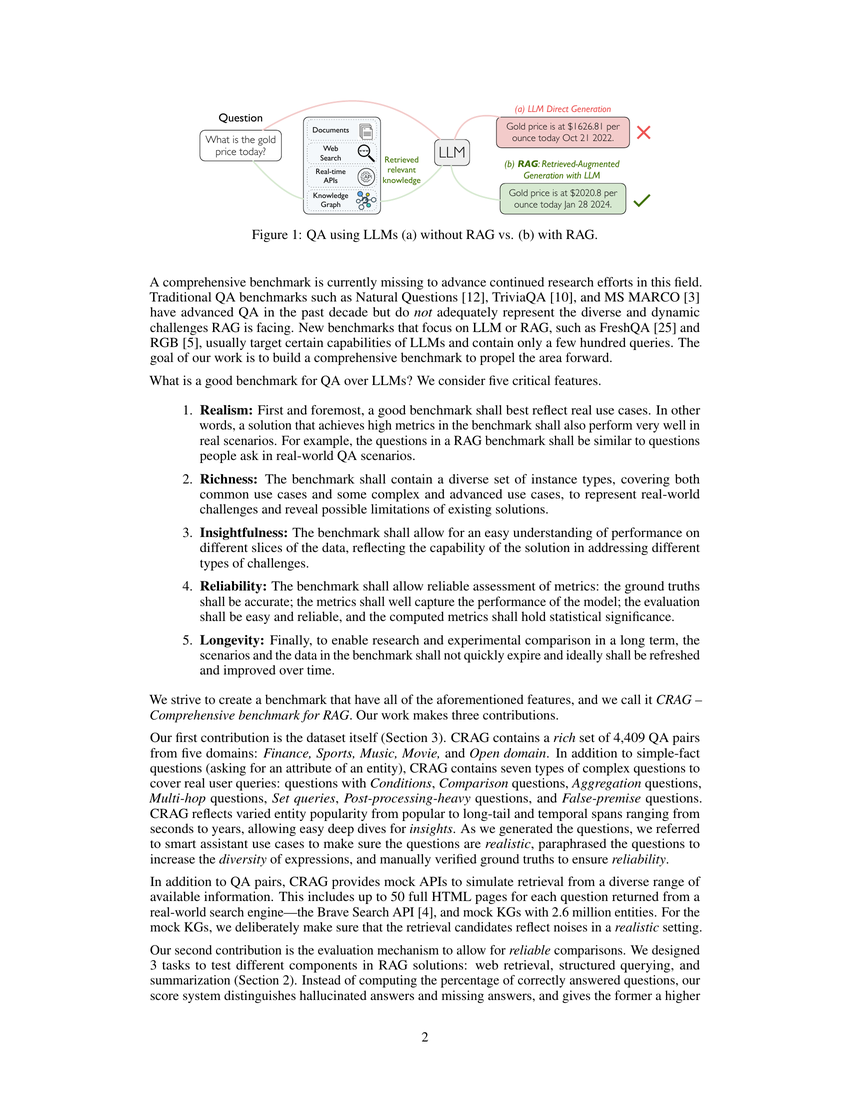
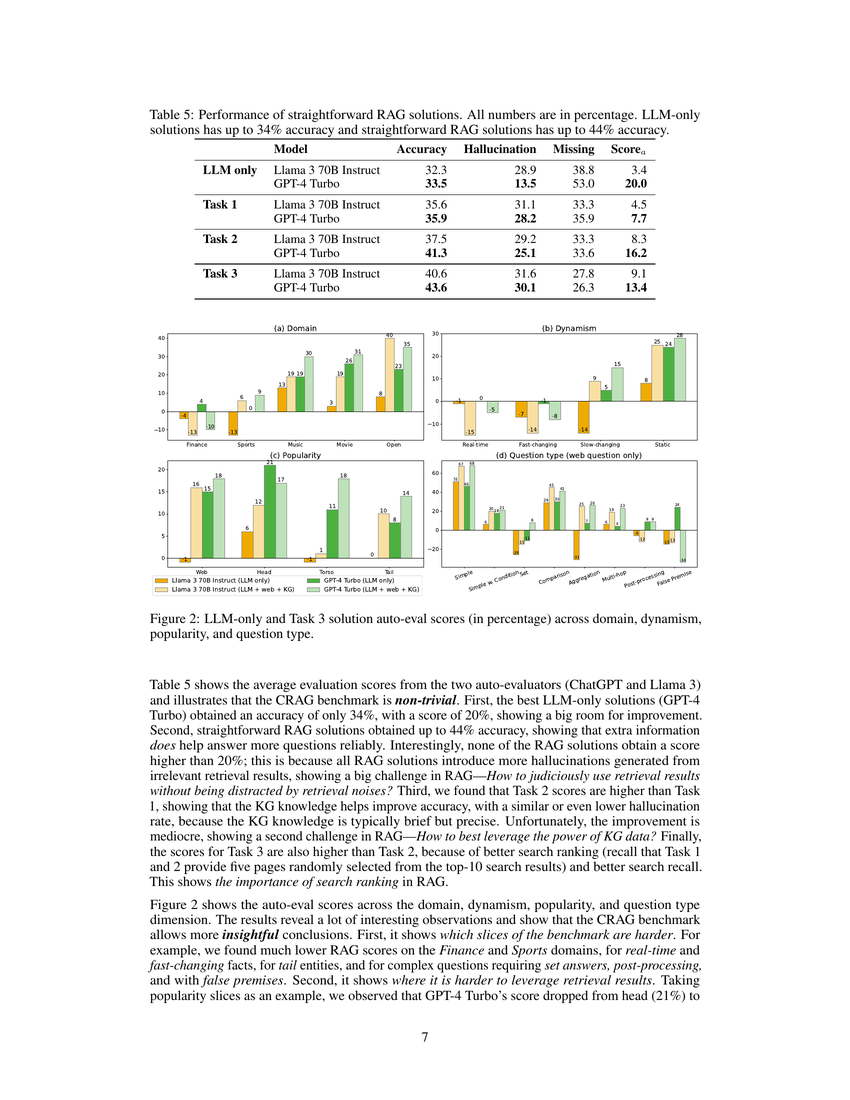
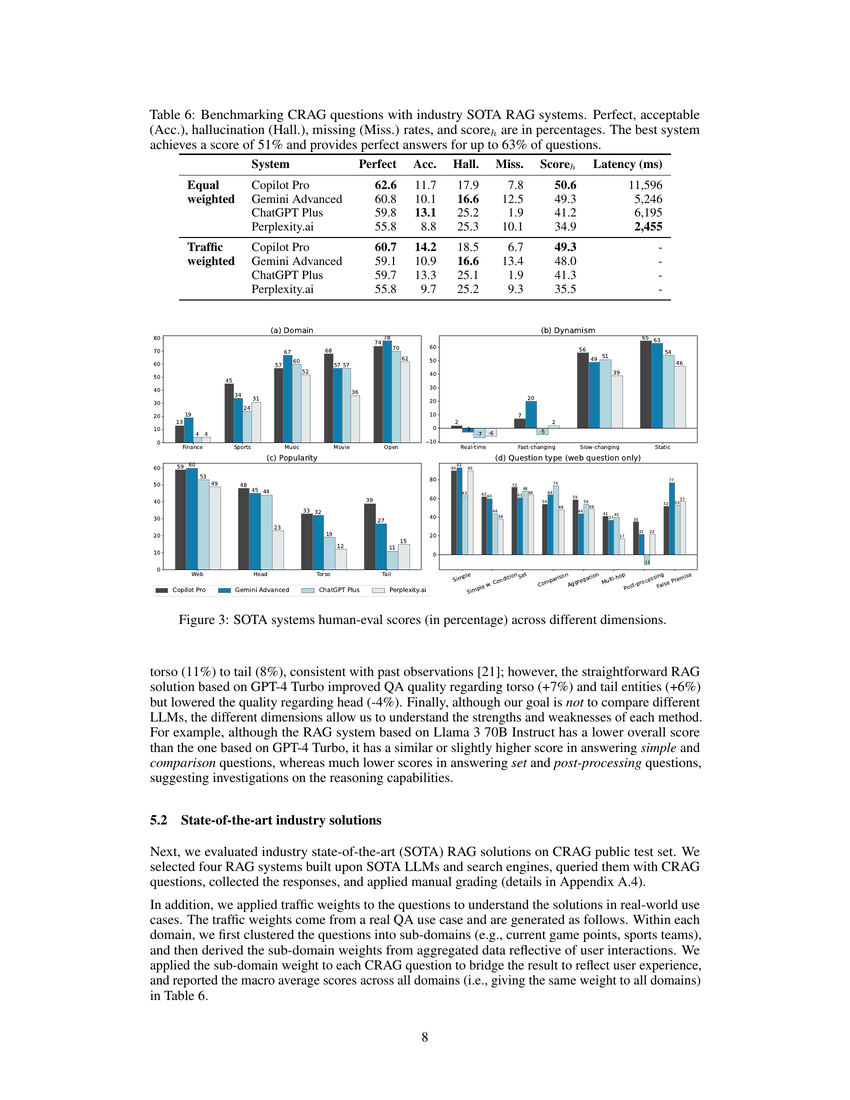

In [17]:
extracted_images

In [18]:
@weave.op()
def replace_images_with_descriptions(paper, images):
    pdf_reader = load_pdf(paper)
    text = ""
    for page_num, page in enumerate(pdf_reader.pages):
        text += page.extract_text() + "\n\n"
        if images[page_num] and len(images[page_num]) > 0:
            text += f"\n\n[Image Descriptions for page {page_num+1}]\n"
            for image_num, image in enumerate(images[page_num]):
                text += f"\n[Image {image_num+1}]: {image['description']}\n"
            text += "[END OF IMAGE DESCRIPTIONS]\n"

    return text

In [19]:
cleaned_text = replace_images_with_descriptions(arxiv_paper, extracted_images)

🍩 https://wandb.ai/a-sh0ts/arxiv-papers-anthropic-testv2-1/r/call/fbb75eda-f30a-44da-870f-d2a44fec104b


In [20]:
cleaned_text[:500]

'CRAG - Comprehensive RAG Benchmark\nXiao Yang˚1, Kai Sun˚1, Hao Xin˚3, Yushi Sun˚3, Nikita Bhalla1, Xiangsen Chen4, Sajal\nChoudhary1, Rongze Daniel Gui1, Ziran Will Jiang1, Ziyu Jiang4, Lingkun Kong1, Brian Moran1,\nJiaqi Wang1, Yifan Ethan Xu1, An Yan1, Chenyu Yang4, Eting Yuan1, Hanwen Zha1, Nan Tang4, Lei\nChen3,4, Nicolas Scheffer1, Yue Liu1, Nirav Shah1, Rakesh Wanga1, Anuj Kumar1, Wen-tau Yih2,\nand Xin Luna Dong1\n1Meta Reality Labs,2FAIR, Meta,3HKUST,4HKUST (GZ)\nAbstract\nRetrieval-Augmented G'

In [21]:
#TODO: Incorporate the question in the summary creation process instead of just using it to create the final summary
@weave.op()
def chain_of_density_summarization(instruction, text, model="claude-3-5-sonnet-20240620", chunk_size=4000, chunk_iterations=2, density_iterations=2):
    """Apply Chain of Density summarization to the text with embedded image descriptions."""
    
    @weave.op()
    def chunk_text(text, chunk_size=4000):
        chunks = []
        current_chunk = ""
        lines = text.split('\n')
        
        i = 0
        while i < len(lines):
            line = lines[i]
            if len(current_chunk) + len(line) > chunk_size:
                if current_chunk:
                    chunks.append(current_chunk.strip())
                    current_chunk = ""
            
            current_chunk += line + "\n"
            
            # Check if this line starts an image description section
            if line.startswith("[Image Descriptions for page"):
                # If we have content before this, add it as a chunk
                if current_chunk.strip():
                    chunks.append(current_chunk.strip())
                    current_chunk = ""
                
                # Collect all image descriptions for this page
                image_descriptions = line + "\n"
                i += 1
                while i < len(lines) and not lines[i].startswith("[END OF IMAGE DESCRIPTIONS]"):
                    image_descriptions += lines[i] + "\n"
                    i += 1
                if i < len(lines):
                    image_descriptions += lines[i] + "\n"
                
                # Add image descriptions as a separate chunk
                chunks.append(image_descriptions.strip())
                current_chunk = ""
            else:
                i += 1
        
        if current_chunk:
            chunks.append(current_chunk.strip())
    
        # Combine chunks until they reach the defined chunk_size
        combined_chunks = []
        current_combined_chunk = ""
        for chunk in chunks:
            if len(current_combined_chunk) + len(chunk) <= chunk_size:
                current_combined_chunk += chunk + "\n\n"
            else:
                if current_combined_chunk:
                    combined_chunks.append(current_combined_chunk.strip())
                current_combined_chunk = chunk + "\n\n"
        
        if current_combined_chunk:
            combined_chunks.append(current_combined_chunk.strip())

        return combined_chunks
    
    # Split the document into chunks
    chunks = chunk_text(text, chunk_size)
    print(f"Number of chunks: {len(chunks)}")
    print(f"Chunk sizes: {[len(chunk) for chunk in chunks]}")
            
    @weave.op()
    def summarize_chunk(chunk, instruction, current_summary="", iteration=1):
        prompt = f"""Current summary:
        {current_summary}

        New information:
        {chunk}

        Instruction to focus on: {instruction}

        Iteration: {iteration}

        Create an extremely dense, highly technical summary that specifically addresses the given instruction. Follow these steps:

        1. Identify 3-5 key technical points from the new information that are directly relevant to the instruction, prioritizing:
        - Novel methodologies or algorithms related to the instruction
        - Specific quantitative results or metrics that address the instruction
        - Detailed experimental setups or parameters pertinent to the instruction
        - Precise definitions of domain-specific concepts mentioned in the instruction
        - Critical limitations or assumptions in the research that affect the instruction

        2. Integrate these points with the current summary, ensuring:
        - Direct relevance to the instruction at hand
        - No redundancy or oversimplification
        - Preservation of technical nuances and complexities specific to the instruction
        - Inclusion of relevant equations, formulas, or mathematical notations that help address the instruction
        - Accurate representation of statistical significance and error margins for instruction-related data

        3. Rephrase the combined information to maximize information density while maintaining focus on the instruction:
        - Use domain-specific terminology and jargon without simplification, as relevant to the instruction
        - Maintain the level of detail expected in a PhD-level discourse on the specific topic of the instruction
        - Incorporate precise citations or references where applicable to support the response
        - Preserve any conflicting viewpoints or ongoing debates in the field that relate to the instruction

        4. With each iteration, aim to increase information density by 30-40% without sacrificing technical accuracy or critical details that address the instruction.

        5. Ensure the summary includes instruction-specific:
        - Methodological details (e.g., exact algorithms, parameter settings) that are crucial to addressing the instruction
        - Precise quantitative results with appropriate units and error bounds that directly relate to the instruction
        - Detailed descriptions of novel techniques or approaches that are key to addressing the instruction
        - Critical analysis of strengths and limitations in the research as they pertain to the instruction

        Produce a summary that is significantly more information-dense and technically precise than the previous one, while remaining laser-focused on addressing the given instruction. Use language appropriate for a highly specialized audience in the field."""

        response = client.messages.create(
            model=model,
            max_tokens=4096,
            messages=[{"role": "user", "content": prompt}]
            )
        return response.content[0].text
    
    @weave.op()
    def summarize_current_summary(instruction, current_summary="", iteration=1):
        prompt = f"""Current summary:
        {current_summary}

        Instruction to focus on: {instruction}

        Iteration: {iteration}

        Generate an increasingly concise, entity-dense, and highly technical summary of the above text that specifically addresses the given instruction.

        Follow these steps:
        1. Identify 1-3 informative technical Entities from the original text which are missing from the current summary and are relevant to the instruction. These entities should be:
        - Highly relevant to addressing the specific instruction
        - Specific and technical (preferably 5 words or fewer)
        - Novel (not in the current summary)
        - Faithful (present in the original text)
        - May include methodologies, algorithms, metrics, or key findings that directly relate to the instruction

        2. Write a new, denser summary of identical length which covers every entity and technical detail from the current summary plus the newly identified Missing Entities, while maintaining focus on addressing the instruction.

        Guidelines:
        - Prioritize technical accuracy and specificity over general readability, always in the context of the given instruction.
        - Make every word count: rewrite the current summary to improve information density and make space for additional technical entities that are relevant to the instruction.
        - Use domain-specific terminology, precise quantitative information, and technical jargon where appropriate and relevant to addressing the instruction.
        - Employ fusion, compression, and removal of less informative phrases to increase density, while ensuring all information pertains to the instruction.
        - Ensure the summary remains highly dense and technical, yet self-contained and focused on the instruction.
        - Never drop entities or technical details from the current summary that are relevant to the instruction. If space is limited, add fewer new entities.
        - Maintain the exact same word count as the current summary.

        Produce a summary that is more information-dense and technically precise than the previous one, suitable for an expert audience in the field, while remaining laser-focused on addressing the given instruction."""

        response = client.messages.create(
            model=model,
            max_tokens=4096,
            messages=[{"role": "user", "content": prompt}]
        )
        return response.content[0].text



    @weave.op()
    def summarize_chunk_summaries(instruction, current_summary, chunk_summaries):
        # Final densification step
        return client.messages.create(
            model="claude-3-opus-20240229", #Ensure it has a long context window
            max_tokens=4096,
            messages=[
                {
                    "role": "user",
                    "content": f"""Given this current summary:

        {current_summary}

        And these chunk summaries:

        {' '.join(chunk_summaries)}

        And this instruction to focus on:

        {instruction}

        Create an extremely dense, final summary that refines the current summary by incorporating key information from the chunk summaries, while specifically addressing the given instruction. Follow these guidelines:

        1. Integrate the most relevant and important information from the chunk summaries into the current summary.
        2. Ensure all key technical content from both the current summary and chunk summaries that relates to the instruction is retained.
        3. Aim to reduce overall length by 30-40% while increasing information density.
        4. Prioritize highly specific methodologies, algorithms, metrics, and findings that directly address the instruction.
        5. Preserve precise quantitative data, including statistical significance and error margins where applicable and relevant to the instruction.
        6. Maintain the use of domain-specific terminology and technical jargon pertinent to the instruction.
        7. Use compact phrasing and remove any remaining non-essential information that doesn't directly contribute to addressing the instruction.
        8. If relevant to the instruction, include brief mentions of limitations, assumptions, or conflicting viewpoints from across all summaries.
        9. Optimize for information density while maintaining coherence for an expert audience, always keeping the focus on the given instruction.

        The final summary should be a highly concentrated, technical distillation of all provided summaries that specifically addresses the given instruction, suitable for specialists in the field.""",
                    }
                ],
        ).content[0].text


    @weave.op()
    def summarize_chunk_iteration(chunks, instruction, current_summary, iteration):
        chunk_summaries = []
        for i, chunk in enumerate(chunks, 1):
            current_summary = summarize_chunk(chunk, instruction, current_summary, iteration)
            chunk_summaries.append(current_summary)
            print(f"Iteration {iteration}, Chunk {i}:\n{current_summary}\n")
        current_summary = summarize_chunk_summaries(instruction, current_summary, chunk_summaries)
        print(f"Iteration {iteration}, Final Summary:\n{current_summary}\n")
        return current_summary

    @weave.op()
    def iterative_chunk_summarization(chunks, instruction, current_summary, chunk_iterations):
        for iteration in range(1, chunk_iterations + 1):
            current_summary = summarize_chunk_iteration(chunks, instruction, current_summary, iteration)
        return current_summary

    current_summary = iterative_chunk_summarization(chunks, instruction, "", chunk_iterations)

    @weave.op()
    def iterative_density_summarization(instruction, current_summary, density_iterations):
        for iteration in range(1, density_iterations + 1):
            current_summary = summarize_current_summary(instruction, current_summary, iteration)
            print(f"Iteration {iteration}:\n{current_summary}\n")
        return current_summary

    current_summary = iterative_density_summarization(instruction, current_summary, density_iterations)

    @weave.op()
    def final_summary(instruction, current_summary):
        # Final densification step
        return client.messages.create(
            model=model,
            max_tokens=4096,
            messages=[
                {
                    "role": "user",
                    "content": f"""Given this summary:

    {current_summary}

    And this instruction to focus on:

    {instruction}

    Create an extremely dense, final summary that captures all key technical information in the most concise form possible, while specifically addressing the given instruction. Follow these guidelines:

    1. Aim to reduce length by 30-40% while retaining all critical technical content relevant to the instruction.
    2. Prioritize highly specific methodologies, algorithms, metrics, and findings that directly address the instruction.
    3. Preserve precise quantitative data, including statistical significance and error margins where applicable and relevant to the instruction.
    4. Maintain the use of domain-specific terminology and technical jargon pertinent to the instruction.
    5. Ensure that all key entities and concepts from the original summary that relate to the instruction are represented.
    6. Use compact phrasing and remove any remaining non-essential information that doesn't directly contribute to addressing the instruction.
    7. If relevant to the instruction, include brief mentions of limitations, assumptions, or conflicting viewpoints.
    8. Optimize for information density while maintaining coherence for an expert audience, always keeping the focus on the given instruction.

    The final summary should be a highly concentrated, technical distillation of the research that specifically addresses the given instruction, suitable for specialists in the field.""",
                }
            ],
        ).content[0].text

    final_summary = final_summary(instruction, current_summary)
    print(f"Final Summary:\n{final_summary}\n")

    return final_summary

In [22]:
question = "Explain the unique evaluation value props this RAG benchmark provides to AI Engineers."

In [23]:
final_summary = chain_of_density_summarization(question, cleaned_text)

Number of chunks: 17
Chunk sizes: [3953, 3563, 1658, 3977, 3968, 3952, 3952, 3443, 3085, 2730, 3946, 3960, 3968, 3977, 3988, 4000, 2]
Iteration 1, Chunk 1:
The Comprehensive RAG Benchmark (CRAG) offers unique evaluation value propositions for AI engineers developing Retrieval-Augmented Generation (RAG) systems:

1. Diverse question corpus: CRAG comprises 4,409 question-answer pairs across 5 domains and 8 question categories, encompassing varied entity popularity (popular to long-tail) and temporal dynamism (years to seconds). This diversity enables comprehensive assessment of RAG systems' performance across a spectrum of real-world QA scenarios.

2. Temporal sensitivity evaluation: CRAG's inclusion of questions with varying temporal dynamism allows for quantitative analysis of RAG systems' ability to handle time-sensitive information. This is crucial for evaluating the freshness and accuracy of retrieved knowledge, with GPT-4 demonstrating <15% accuracy for fast-changing facts [25].

3

In [28]:
class ArxivChainOfDensityPipeline(weave.Model):

    model: str = "claude-3-5-sonnet-20240620"
    chunk_size: int = 4000
    chunk_iterations: int = 1
    density_iterations: int = 3

    def __init__(self, model: str = "claude-3-5-sonnet-20240620", chunk_size: int = 4000, chunk_iterations: int = 1, density_iterations: int = 3):
        super().__init__()
        self.model = model
        self.chunk_size = chunk_size
        self.chunk_iterations = chunk_iterations
        self.density_iterations = density_iterations

    @weave.op()
    def predict(self, paper: ArxivPaper, instruction: str) -> str:
        extracted_images = extract_images(paper)
        cleaned_text = replace_images_with_descriptions(paper, extracted_images)
        return chain_of_density_summarization(instruction, cleaned_text, model=self.model, chunk_size=self.chunk_size, chunk_iterations=self.chunk_iterations, density_iterations=self.density_iterations)

In [29]:
arxiv_chain_of_density_pipeline = ArxivChainOfDensityPipeline()
arxiv_chain_of_density_pipeline.predict(arxiv_paper, "Determine how I would best incorporate these benchmarks for my customer support RAG system. What evaluations would work best specifically for me?")

Number of chunks: 17
Chunk sizes: [3953, 3563, 1735, 3977, 3968, 3952, 3952, 3933, 3085, 1853, 3946, 3960, 3968, 3977, 3988, 4000, 2]
Iteration 1, Chunk 1:
To optimize a customer support RAG system using the CRAG benchmark, consider the following key technical points:

1. Domain-specific evaluation: CRAG encompasses 5 domains and 8 question categories, enabling targeted assessment of customer support-related queries. Implement a subset selection algorithm to isolate relevant domains/categories, prioritizing those aligning with your support ecosystem (e.g., product specifications, troubleshooting procedures).

2. Temporal dynamism simulation: CRAG's temporal range (years to seconds) allows evaluation of RAG performance on time-sensitive customer inquiries. Develop a time-decay weighted accuracy metric (A_td) where A_td = Σ(w_i * a_i) / Σw_i, with w_i as time-sensitivity weight and a_i as per-question accuracy.

3. Entity popularity stratification: Leverage CRAG's entity popularity spect

"Optimized CS RAG Evaluation:\nH_schema = E_crag ∪ E_cs. Benchmark: (1) Fine-tuned Llama 3 70B Instruct, 5-fold CV; (2) GPT-4 Turbo, active learning, τ = f(complexity, entities, criticality). Score_cs = w1*Accuracy + w2*(1-Hallucination) + w3*Relevance + w4*Resolution_Time. M(q) = argmax_m {Score_cs(m, q) | Latency(m, q) ≤ SLA(q)}. Update w_i = w_i - η * ∂Δ/∂w_i, retrain on D' = D ∪ {(q, r, F_human)}. Implement question-type stratification, dynamism categorization, entity-dense JSON schema. Evaluate multi-hop reasoning, false premise detection, domain adaptations. Focus: post-processing, CS-specific assessment via stratified sampling and dynamic content handling. Prioritize benchmarks targeting accuracy, hallucination reduction, relevance, and resolution time within SLA constraints. Adapt evaluation metrics to CS-specific needs, emphasizing real-world performance and user satisfaction."